In [1]:
import os
import numpy as np
import cv2, pydicom
import matplotlib.pyplot as plt

In [2]:
class Dicom():
    def __init__(self, dicom_path=None, window_center=None, window_width=None, auto=None):
        self.dicom_path = dicom_path
        self.window_center = window_center
        self.window_width = window_width
        self.auto = auto
        
        self.hu_img = self.dicom_to_array(self.dicom_path)
        if auto == "all":
            self.window_center, self.window_width = self.get_min_max_window(self.hu_img)
        if self.window_center is not None and self.window_width is not None:
            self.img = self.dicom_windowing(self.hu_img, self.window_center, self.window_width)

    def dicom_to_array(self, dicom_path):
        self.slice = pydicom.read_file(dicom_path)
        s = int(self.slice.RescaleSlope)
        b = int(self.slice.RescaleIntercept)
        return s * self.slice.pixel_array + b

    def get_min_max_window(self, hu_img):
        img_min = np.min(hu_img)
        img_max = np.max(hu_img)
        window_center = (img_max + img_min) / 2
        window_width = img_max - img_min
        return window_center, window_width

    def dicom_windowing(self, image, window_center, window_width):
        img_min = window_center - window_width / 2
        img_max = window_center + window_width / 2
        window_img = np.clip(image, img_min, img_max)
        return window_img
    
    def get_image(self):
        return self.img
    
    def get_hu_image(self):
        return self.hu_img
    
    def change_window(self, window_center, window_width):
        self.window_center = window_center
        self.window_width = window_width
        self.img = self.dicom_windowing(self.hu_img, self.window_center, self.window_width)

In [3]:
data_list = os.listdir('data/Sample1')
dicom_path = os.path.join('data/Sample1',data_list[0])
dicom_file = Dicom(dicom_path=dicom_path, auto="all")
image = dicom_file.get_image()
hu_img = dicom_file.get_hu_image()

In [4]:
print(data_list[0])

4625.38405.33988.17340.36372.43091.37138.15103.100.0.dcm


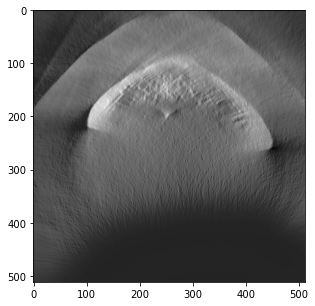

In [5]:
plt.figure(figsize=(10,5))
plt.imshow(hu_img, cmap='gray')

Text(0.5, 1.0, 'Window Center : 290.5, Window Width : 1275')

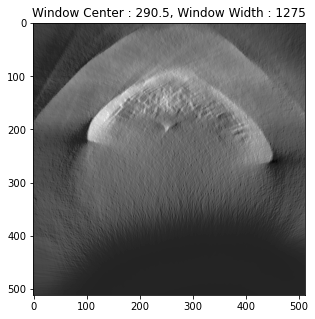

In [6]:
plt.figure(figsize=(10,5))
plt.imshow(image, cmap="gray")
plt.title(f"Window Center : {dicom_file.window_center}, Window Width : {dicom_file.window_width}")

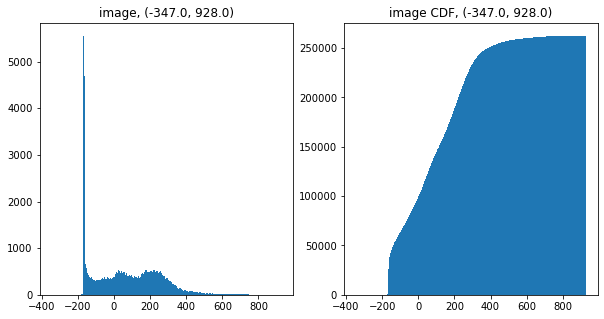

In [7]:
hist1, bins1 = np.histogram(image.flatten(), int(np.max(image) - np.min(image) + 1), [np.min(image), np.max(image) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(image.flatten(), bins1)
plt.title(f"image, {np.min(image), np.max(image)}")
plt.subplot(1, 2, 2)
plt.hist(image.flatten(), bins1, cumulative=True)
plt.title(f"image CDF, {np.min(image), np.max(image)}")
plt.show()

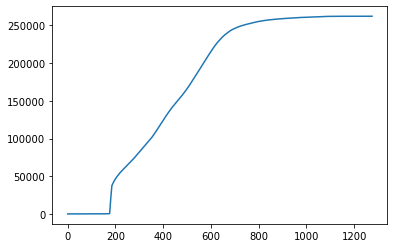

In [8]:
cdf1 = hist1.cumsum()
plt.plot(cdf1)

In [9]:
cdf1.shape

(1276,)

In [12]:
a = np.linspace(np.min(image), np.max(image) - 1, 1276)

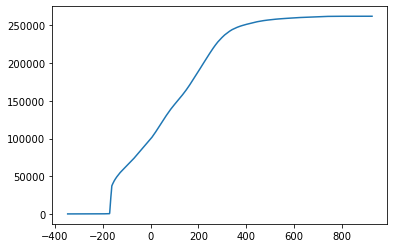

In [13]:
plt.plot(a, cdf1)

In [14]:
np.where(cdf1 < cdf1[-1] * 0.02)[0][-1]

176

In [15]:
clip_min = np.min(image) + np.where(cdf1 < cdf1[-1] * 0.02)[0][-1]

In [16]:
np.where(cdf1 > cdf1[-1] * 0.99)[0][0]

927

In [17]:
clip_max = np.min(image) + np.where(cdf1 > cdf1[-1] * 0.99)[0][0]

In [18]:
window_center = (clip_max + clip_min) / 2
window_width = (clip_max - clip_min)

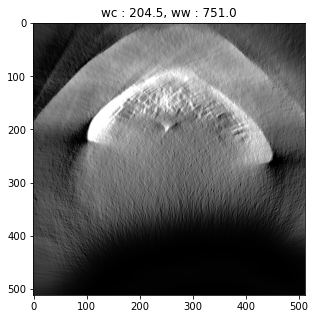

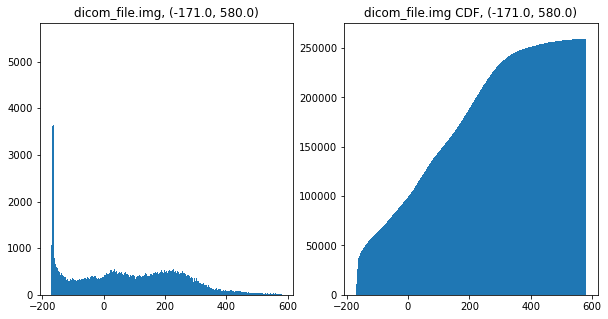

In [19]:
dicom_file.change_window(window_center, window_width)
plt.figure(figsize=(10,5))
plt.imshow(dicom_file.img, cmap="gray")
plt.title(f"wc : {window_center}, ww : {window_width}")

hist2, bins2 = np.histogram(dicom_file.img.flatten(), int(np.max(dicom_file.img) - np.min(dicom_file.img) + 1), [np.min(dicom_file.img), np.max(dicom_file.img) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(dicom_file.img.flatten(), bins2)
plt.title(f"dicom_file.img, {np.min(dicom_file.img), np.max(dicom_file.img)}")
plt.subplot(1, 2, 2)
plt.hist(dicom_file.img.flatten(), bins2, cumulative=True)
plt.title(f"dicom_file.img CDF, {np.min(dicom_file.img), np.max(dicom_file.img)}")
plt.show()

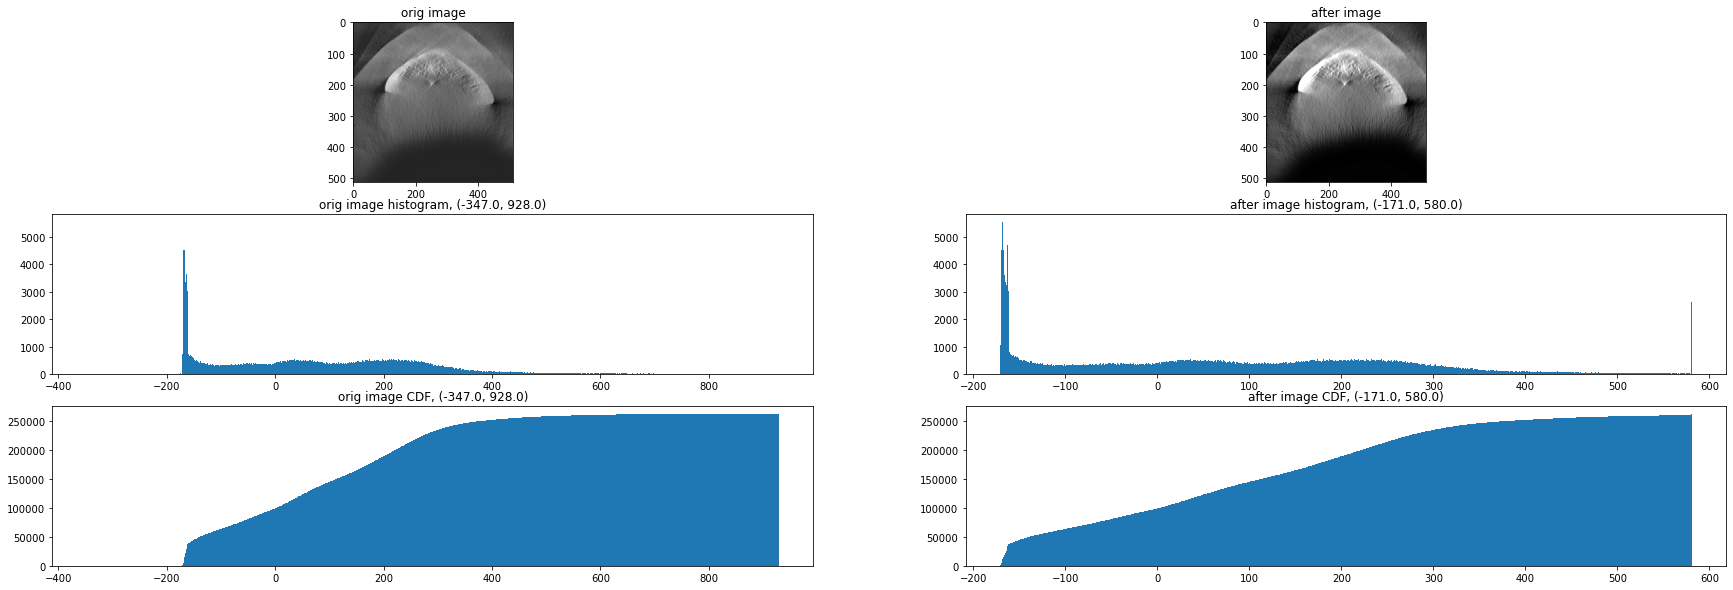

In [20]:
plt.figure(figsize=(30,10))
plt.subplot(3, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("orig image")

plt.subplot(3, 2, 2)
plt.imshow(dicom_file.img, cmap='gray')
plt.title("after image")

plt.subplot(3, 2, 3)
plt.hist(image.flatten(), bins1)
plt.title(f"orig image histogram, {np.min(image), np.max(image)}")

plt.subplot(3, 2, 4)
plt.hist(dicom_file.img.flatten(), bins2)
plt.title(f"after image histogram, {np.min(dicom_file.img), np.max(dicom_file.img)}")

plt.subplot(3, 2, 5)
plt.hist(image.flatten(), bins1, cumulative=True)
plt.title(f"orig image CDF, {np.min(image), np.max(image)}")

plt.subplot(3, 2, 6)
plt.hist(dicom_file.img.flatten(), bins2, cumulative=True)
plt.title(f"after image CDF, {np.min(dicom_file.img), np.max(dicom_file.img)}")
plt.show()